### Парсим данные через yfinance

In [1]:
# from utils.parser import parse_single_ticker

# parse_single_ticker(
#     ticker="MSFT",
#     path_to_save='data/',
#     timeframe='1d',
#     start_date='2020-01-01',
#     target_len=32,
#     history_len=256,
#     split_coef=0.1,
# )

In [ ]:
# from utils.parser import parse_snp500

# parse_snp500(
#     path_to_save='data/',
#     timeframe='1d',
#     start_date='2020-01-01',
#     target_len=32,
#     history_len=256,
#     split_coef=0.1,
# )

### Получаем датасет

In [1]:
from utils.dataset import TradingDataset, TradingNormalizer

normalizer = TradingNormalizer(method='log_returns')

dataset = TradingDataset(
    data_path='data/',
    mode='train',
    history_len=256,
    target_len=32,
    normalizer=normalizer,
)

Found 507130 samples for train mode


History shape: torch.Size([1, 256, 5])
Target shape: torch.Size([1, 32, 1])
Ticker: URI
Stats: {'first_price_0': np.float32(164.23398), 'first_price_1': np.float32(164.86482), 'first_price_2': np.float32(162.30261), 'first_price_3': np.float32(163.68077), 'volume_mean': np.float32(759038.9), 'volume_std': np.float32(300887.7)}


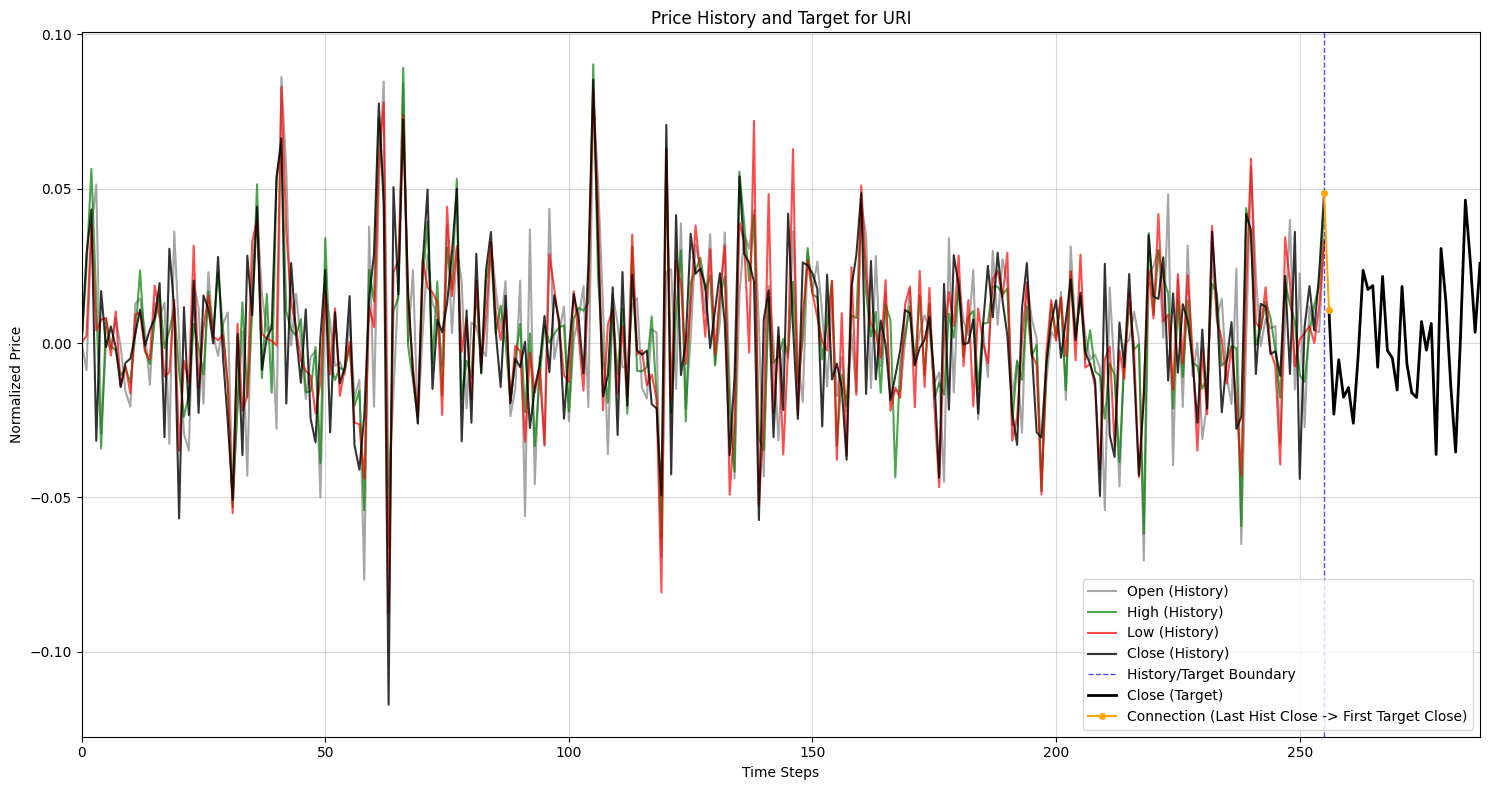

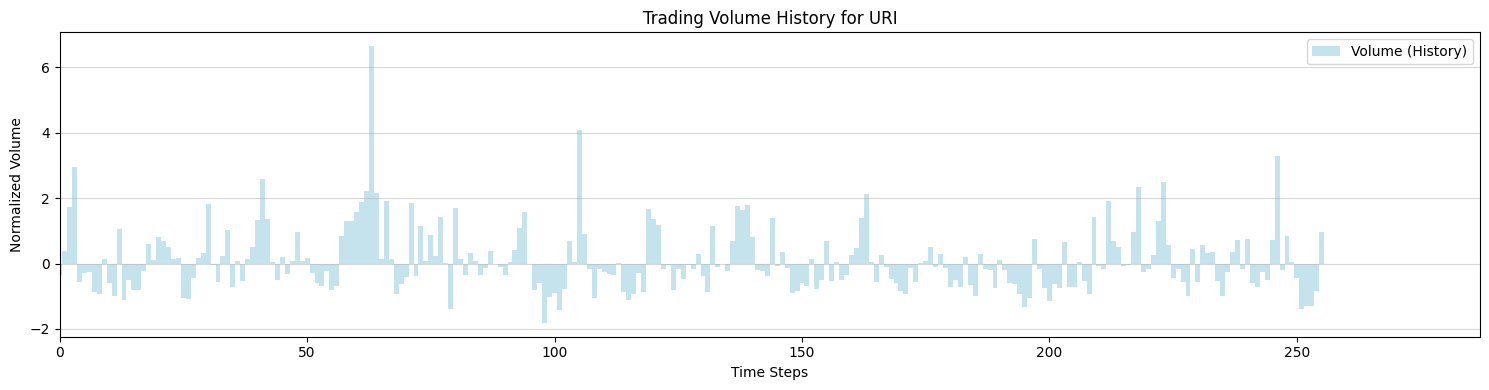

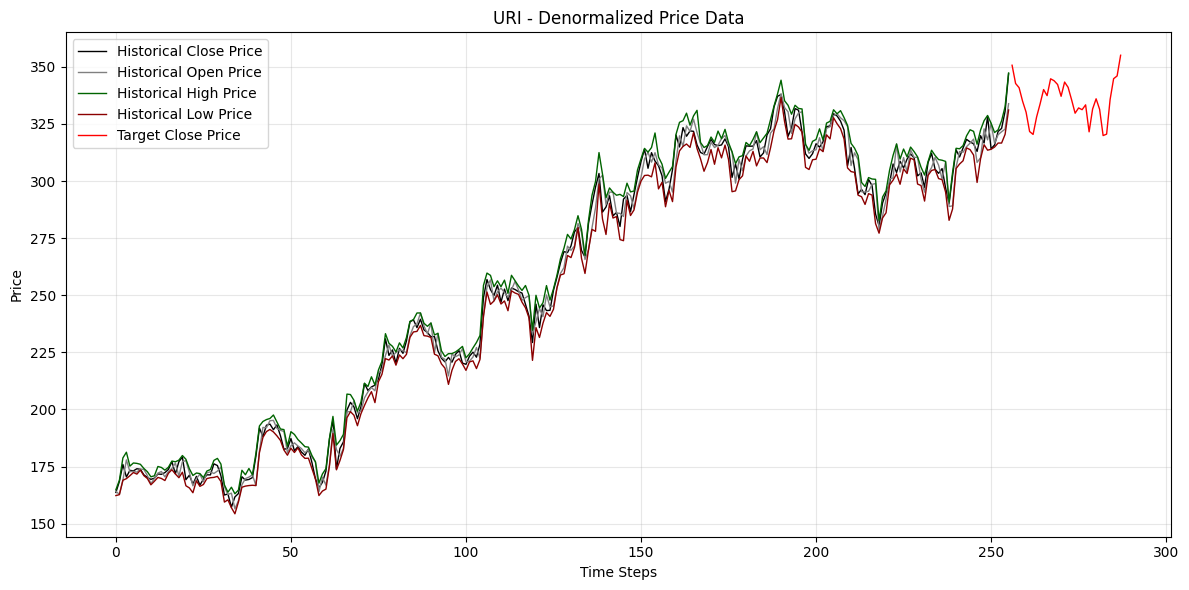

In [4]:
import torch
from utils.visualization import plot_dataset_sample, plot_denormalized_sample


idx = torch.randint(0, len(dataset), (1,)).item()
# idx = 0
sample = dataset[idx]
print(f"History shape: {sample['history'].shape}")
print(f"Target shape: {sample['target'].shape}")
print(f"Ticker: {sample['ticker']}")
print(f"Stats: {sample['stats']}")


plot_dataset_sample(sample)
plot_denormalized_sample(sample)

In [3]:
# from utils.dataset import TradingDataset

# dataset = TradingDataset(data_path='data/', mode='train')

In [4]:
# import torch
# from utils.visualization import plot_dataset_sample

# sample = dataset[torch.randint(0, len(dataset), (1,)).item()]

# print("History shape:", sample['history'].shape)   # torch.Size([1, 256, 5])
# print("Target shape:", sample['target'].shape)     # torch.Size([1, 32, 1])
# print("Ticker:", sample['ticker'])

# plot_dataset_sample(sample)